# WOE logistic regression pitfalls

Author: https://www.github.com/deburky

In [1]:
import warnings
from itertools import combinations

import numpy as np
import pandas as pd
from fastwoe import FastWoe
from matplotlib import pyplot as plt
from sklearn.base import clone
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

In [39]:
X, y = make_classification(
    n_samples=1000,
    n_features=5,
    n_informative=3,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.03,
    random_state=42,
)

X = pd.DataFrame(X, columns=[f"x_{i}" for i in range(X.shape[1])])
y = pd.Series(y, name="y")

### Sign flips

In [40]:
raw_corr_matrix = X.corr()
raw_corr_matrix.style.background_gradient(cmap="Blues").format("{:.1%}")

,x_0,x_1,x_2,x_3,x_4
x_0,100.0%,-0.0%,-2.3%,-1.2%,0.5%
x_1,-0.0%,100.0%,2.0%,17.4%,-2.4%
x_2,-2.3%,2.0%,100.0%,-60.8%,3.5%
x_3,-1.2%,17.4%,-60.8%,100.0%,-8.3%
x_4,0.5%,-2.4%,3.5%,-8.3%,100.0%


In [41]:
# Create a variable that correlates with the rest of the set
X["x_5"] = X["x_0"] + X["x_1"] + X["x_2"] + X["x_3"] + X["x_4"]

In [42]:
upd_corr_matrix = X.corr()
upd_corr_matrix.style.background_gradient(cmap="Blues").format("{:.1%}")

,x_0,x_1,x_2,x_3,x_4,x_5
x_0,100.0%,-0.0%,-2.3%,-1.2%,0.5%,48.1%
x_1,-0.0%,100.0%,2.0%,17.4%,-2.4%,64.5%
x_2,-2.3%,2.0%,100.0%,-60.8%,3.5%,21.9%
x_3,-1.2%,17.4%,-60.8%,100.0%,-8.3%,16.9%
x_4,0.5%,-2.4%,3.5%,-8.3%,100.0%,46.4%
x_5,48.1%,64.5%,21.9%,16.9%,46.4%,100.0%


In [43]:
pipe = Pipeline(
    [
        (
            "binning",
            FastWoe(binner_kwargs={"strategy": "quantile", "n_bins": 5}),
        ),
        ("model", LogisticRegression(fit_intercept=True)),
    ]
)

# Without correlated factor
X_orig = X.copy().drop(columns=["x_5"])
pipe_orig = clone(pipe)
pipe_orig[0].variable_names = list(X_orig.columns)

# pipeline without x_6
pipe_orig.fit(X_orig, y)

# Print coefficients
coef_results_orig = pd.DataFrame(
    {"feature": X_orig.columns, "coef": pipe_orig.named_steps["model"].coef_[0]}
)
display(coef_results_orig)

# With correlated factor
pipe.fit(X, y)
coef_results = pd.DataFrame(
    {"feature": X.columns, "coef": pipe.named_steps["model"].coef_[0]}
)
display(coef_results)

roc_auc = roc_auc_score(y, pipe.predict_proba(X)[:, 1])
roc_auc_orig = roc_auc_score(y, pipe_orig.predict_proba(X_orig)[:, 1])
print(roc_auc, roc_auc_orig)
(
    log_loss(y, pipe.predict_proba(X)[:, 1]),
    log_loss(y, pipe_orig.predict_proba(X_orig)[:, 1]),
)

,feature,coef
0,x_0,0.277767
1,x_1,0.895691
2,x_2,0.758532
3,x_3,1.488302
4,x_4,0.102627


,feature,coef
0,x_0,0.299784
1,x_1,0.949827
2,x_2,0.758175
3,x_3,1.452882
4,x_4,0.038540
5,x_5,-0.267718


0.9592533480535688 0.9592373477975649


(0.2489209033478401, 0.2507915800952679)

In [8]:
# Select a few rows to illustrate
rows_to_show = X.iloc[:3].copy()  # first 3 samples, you can pick others

# Get WOE-transformed values from the fitted binning step
woe_values = pipe.named_steps["binning"].transform(rows_to_show)

# Extract coefficients from logistic regression
coefs = pipe.named_steps["model"].coef_[0]
feature_names = X.columns

# Build table row by row
table_rows = []
for idx in rows_to_show.index:
    row_data = {"Y": "?"}  # Placeholder for label if unknown
    for feat, coef in zip(feature_names, coefs, strict=False):
        x_val = X.loc[idx, feat]
        woe_val = woe_values.loc[idx, feat]  # WOE-transformed value
        row_data |= {
            f"{feat}": round(x_val, 2),
            f"β_{feat}": round(coef, 2),
            f"ω_{feat}(x_{feat})": round(woe_val, 2),
        }
    table_rows.append(row_data)

table_df = pd.DataFrame(table_rows)

# Display as a nice table
display(table_df)

,Y,x_0,β_x_0,ω_x_0(x_x_0),x_1,β_x_1,ω_x_1(x_x_1),x_2,β_x_2,ω_x_2(x_x_2),x_3,β_x_3,ω_x_3(x_x_3),x_4,β_x_4,ω_x_4(x_x_4),x_5,β_x_5,ω_x_5(x_x_5)
0,?,-0.69,0.3,0.03,1.30,0.95,4.18,-2.45,0.76,1.44,1.67,1.45,-0.21,-0.02,0.04,0.09,-0.19,-0.27,-0.13
1,?,-0.90,0.3,-0.03,-0.46,0.95,-2.45,-1.25,0.76,-0.76,1.52,1.45,-0.01,-0.11,0.04,0.09,-1.19,-0.27,-0.54
2,?,-0.34,0.3,0.03,-1.53,0.95,-4.19,-0.62,0.76,-0.72,0.41,1.45,0.09,1.16,0.04,-0.13,-0.92,-0.27,-0.54


In [9]:
X.head(3).round(2)

,x_0,x_1,x_2,x_3,x_4,x_5
0,-0.69,1.30,-2.45,1.67,-0.02,-0.19
1,-0.90,-0.46,-1.25,1.52,-0.11,-1.19
2,-0.34,-1.53,-0.62,0.41,1.16,-0.92


In [10]:
pipe[0].transform(X.head(3)).round(2)

,x_0,x_1,x_2,x_3,x_4,x_5
0,0.03,4.18,1.44,-0.21,0.09,-0.13
1,-0.03,-2.45,-0.76,-0.01,0.09,-0.54
2,0.03,-4.19,-0.72,0.09,-0.13,-0.54


In [11]:
pipe[1].coef_

array([[ 0.29978361,  0.94982702,  0.75817549,  1.45288214,  0.03853974,
        -0.2677182 ]])

In [12]:
# Assuming your coefficient column is named 'coef' or is the second column
def highlight_(val):
    try:
        if pd.isna(val):
            return ""
        num_val = float(val)
        if num_val > 0:
            return "background-color: #FF8EFF"
        elif num_val < 0:
            return "background-color: #7EFF7E"
        else:
            return ""  # for zero values
    except (ValueError, TypeError):
        return ""


# Apply only to the coefficient column
# coef_results['coef'] *= -1
coef_results.style.applymap(
    highlight_, subset=["coef"]
)  # Replace 'coef' with your actual column name

,feature,coef
0,x_0,0.299784
1,x_1,0.949827
2,x_2,0.758175
3,x_3,1.452882
4,x_4,0.038540
5,x_5,-0.267718


In [13]:
# Transpose the DataFrame first
coef_results_orig["coef"] *= -1
coef_transposed = coef_results_orig.transpose()

# Then apply styling (you'll need to identify which row contains the coefficients)
styled_df = coef_transposed.style.applymap(highlight_)
styled_df

,0,1,2,3,4
feature,x_0,x_1,x_2,x_3,x_4
coef,-0.277767,-0.895691,-0.758532,-1.488302,-0.102627


In [15]:
import pandas as pd
import numpy as np

# Select a few rows to illustrate
rows_to_show = X.iloc[:3].copy()

# Get WOE-transformed values
woe_values = pipe.named_steps["binning"].transform(rows_to_show)

# Get coefficients and intercept
coefs = pipe.named_steps["model"].coef_[0]
intercept = pipe.named_steps["model"].intercept_[0]

# Only keep first 3 features
feature_names = X.columns[:3]
coefs = coefs[:3]

table_rows = []
for idx in rows_to_show.index:
    row_data = {"Y": "?"}
    contribs = []
    for feat, coef in zip(feature_names, coefs, strict=False):
        x_val = X.loc[idx, feat]
        woe_val = woe_values.loc[idx, feat]
        contrib = coef * woe_val
        contribs.append(contrib)
        row_data |= {
            f"{feat}": round(x_val, 2),
            f"ω({feat})": round(woe_val, 2),
            f"β({feat})": round(coef, 2),
            f"βω({feat})": round(contrib, 2),
        }
    total_logit = intercept + np.sum(contribs)
    prob = 1 / (1 + np.exp(-total_logit))
    row_data["Logit (Σβω + intercept)"] = round(total_logit, 2)
    row_data["P(y=1)"] = round(prob, 3)
    table_rows.append(row_data)

table_df = pd.DataFrame(table_rows)
display(table_df)

,Y,x_0,ω(x_0),β(x_0),βω(x_0),x_1,ω(x_1),β(x_1),βω(x_1),x_2,ω(x_2),β(x_2),βω(x_2),Logit (Σβω + intercept),P(y=1)
0,?,-0.69,0.03,0.3,0.01,1.30,4.18,0.95,3.97,-2.45,1.44,0.76,1.09,5.06,0.994
1,?,-0.90,-0.03,0.3,-0.01,-0.46,-2.45,0.95,-2.33,-1.25,-0.76,0.76,-0.58,-2.93,0.051
2,?,-0.34,0.03,0.3,0.01,-1.53,-4.19,0.95,-3.98,-0.62,-0.72,0.76,-0.54,-4.53,0.011


In [16]:
pipe.predict_proba(X.head(3))[:, 1]

array([0.99176119, 0.05782394, 0.01397867])

In [17]:
# Check against intercept
sample_log_odds = np.log(y.mean()) - np.log(1 - y.mean())
sample_log_odds, pipe_orig[-1].intercept_, pipe[-1].intercept_

(np.float64(0.008000042667076324), array([0.00685935]), array([-0.01398437]))

Watch out for correlated factors and avoid double counting.

### Intercept shifts

#### Scikit-learn implementation

In [15]:
X, y = make_classification(
    n_samples=10_000,
    n_features=10,
    n_informative=5,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.03,
    random_state=42,
)

X = pd.DataFrame(X, columns=[f"x_{i}" for i in range(X.shape[1])])
y = pd.Series(y, name="y")

features = list(X.columns)

pipe = Pipeline(
    [
        (
            "binning",
            FastWoe(binner_kwargs={"strategy": "quantile", "n_bins": 5}),
        ),
        ("model", LogisticRegression()),
    ]
)

rows = []

for k in range(1, len(features) + 1):  # try 1..N features
    for cols in combinations(features, k):
        # clone the pipeline so we don't mutate the original
        p = clone(pipe)

        # fit on the subset
        X_sub = X.loc[:, cols]
        p.fit(X_sub, y)

        # pull intercept(s) from the final model
        intercept = p.named_steps["model"].intercept_

        rows.append(
            {
                "feature_set": cols,  # which exact features were used
                "n_features": len(cols),  # a) count of features
                "intercept": (
                    float(intercept[0]) if intercept.size == 1 else intercept.copy()
                ),  # b)
            }
        )

results = pd.DataFrame(rows)

# Calculate sample log odds
sample_log_odds = np.log(y.mean()) - np.log((1 - y).mean())
print(f"Sample log odds: {sample_log_odds:.4f}")

grouped_results = (
    results.groupby("n_features").agg(
        intercept_mean=("intercept", "mean")
    )  # name directly
)
grouped_results["log_odds_avg"] = sample_log_odds
grouped_results["diff"] = grouped_results["intercept_mean"] - sample_log_odds
grouped_results

Sample log odds: 0.0120


,intercept_mean,log_odds_avg,diff
n_features,,,
1,0.012047,0.012,0.000047
2,0.011015,0.012,-0.000985
3,0.009442,0.012,-0.002558
4,0.007551,0.012,-0.004450
5,0.005661,0.012,-0.006339
6,0.004068,0.012,-0.007932
7,0.003083,0.012,-0.008917
8,0.002919,0.012,-0.009081
9,0.003995,0.012,-0.008005


In [16]:
# sklearn implementation
SIZES = [100, 500, 1_000, 5_000, 10_000]
N_FEATURES = 10
MAKE_KW = dict(
    n_features=N_FEATURES,
    n_informative=5,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.03,
    weights=[0.95, 0.05],
    random_state=42,
)

pipe = Pipeline(
    [
        (
            "binning",
            FastWoe(binner_kwargs={"strategy": "quantile", "n_bins": 5}),
        ),
        ("model", LogisticRegression()),
    ]
)

all_grouped = []  # will collect per-size grouped results

for n in SIZES:
    X, y = make_classification(n_samples=n, **MAKE_KW)
    X = pd.DataFrame(X, columns=[f"x_{i}" for i in range(X.shape[1])])
    y = pd.Series(y, name="y")
    features = list(X.columns)

    rows = []
    for k in range(1, len(features) + 1):  # try 1..N features
        for cols in combinations(features, k):
            p = clone(pipe)

            X_sub = X.loc[:, cols]
            p.fit(X_sub, y)

            # Extract intercept (index 0) and feature coefficients (index 1+)
            intercept_ = p.named_steps["model"].intercept_
            intercept = float(intercept_[0])  # intercept is always at index 0
            # feature_coefs = beta[1:] if len(beta) > 1 else []

            rows.append(
                {
                    "feature_set": cols,
                    "n_features": len(cols),
                    "intercept": intercept,
                }
            )

    results = pd.DataFrame(rows)

    # Baseline sample log-odds (no-feature model)
    p_hat = y.mean()
    sample_log_odds = np.log(p_hat) - np.log(1 - p_hat)

    # Aggregate by number of features
    grouped = (
        results.groupby("n_features")
        .agg(
            intercept_mean=("intercept", "mean"),
            intercept_std=("intercept", "std"),
            n_models=("intercept", "size"),
        )
        .reset_index()
    )
    grouped["log_odds_avg"] = sample_log_odds
    grouped["diff"] = grouped["intercept_mean"] - sample_log_odds
    grouped["diff_std"] = grouped["intercept_std"]  # std is invariant to constant shift
    grouped["n_samples"] = n

    all_grouped.append(grouped)

combined = pd.concat(all_grouped, ignore_index=True)

# average shift at max feature count per sample size
summary = (
    combined.sort_values(["n_samples", "n_features"])
    .groupby("n_samples")
    .tail(1)[["n_samples", "n_features", "diff", "diff_std", "n_models"]]
)
print("\nSummary at max feature count:")
print(summary.to_string(index=False))


Summary at max feature count:
 n_samples  n_features     diff  diff_std  n_models
       100          10 4.728376       NaN         1
       500          10 0.095216       NaN         1
      1000          10 0.065057       NaN         1
      5000          10 0.060732       NaN         1
     10000          10 0.016166       NaN         1


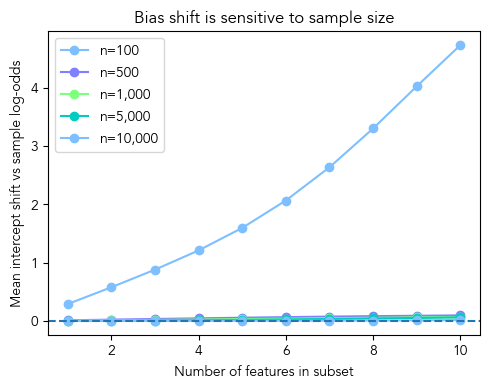

In [33]:
colors = ["#7ebfff", "#7f7fff", "#7eff7e", "#03CBC0"]

# Set font to Virgil GS
plt.rcParams["font.family"] = "Avenir"

# Plot: mean intercept shift vs number of features, by sample size
plt.figure(figsize=(5, 4), dpi=100)
for i, n in enumerate(SIZES):
    df_n = combined[combined["n_samples"] == n]
    plt.plot(
        df_n["n_features"],
        df_n["diff"],
        marker="o",
        label=f"n={n:,.0f}",
        color=colors[i % len(colors)],
    )
plt.axhline(0.0, linestyle="--")
plt.xlabel("Number of features in subset")
plt.ylabel("Mean intercept shift vs sample log-odds")
plt.title("Bias shift is sensitive to sample size")
plt.legend()
plt.tight_layout()
plt.savefig("bias_shift_vs_sample_size.png", transparent=True, dpi=250)
plt.show()